In [27]:
'''Basic Libraries'''
import pandas as pd 
import numpy as np 
from pathlib import Path
import matplotlib.pyplot as plt 
import os.path 
import regex as re
import warnings 
import math
import itertools
warnings.filterwarnings('ignore')


'''Preprocessing and Modeliing Libraries'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, AveragePooling2D, Input, Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.utils import to_categorical, plot_model
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
#CONFIG 
BASE_DIR = '/content/drive/MyDrive/trainPart12'
NUM_CLASSES = 62
n = 3 #layers of Resnet Model
BATCH_SIZE = 32
EPOCHS = 100
IMG_HEIGHT = 900 
IMG_WIDTH = 1200
RATIO = 4
RANDOM_STATE = 2018

## Data collection and Preprocessing 

Extracting images and assigning them labes according to their folder name 

In [9]:
filepaths = list(Path(BASE_DIR).glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

#Concatenating filepaths and image labels into a dataframe
image_df = pd.concat([filepaths, labels], axis=1)

In [10]:
# Doing some preprocessing to extract  specific labels from 1 to 62
image_df['new_labels'] = [re.findall(r'\d+', x) for x in image_df['Label']]
image_df['new_labels'] = image_df['new_labels'].astype(str).str.replace(r'\[|\]|,','')
image_df['new_labels'] = image_df['new_labels'].astype(str).str.replace(r"[\"\',]",'').astype(int)

# Converting the target column into list
label_list = image_df['new_labels'].values.reshape(-1,1)

In [11]:
image_width = int(IMG_WIDTH/RATIO)
image_height = int(IMG_HEIGHT/RATIO)
channels = 3

# Now We need to extract values of each pixel from our Images and store them in a ndarray so that our model can learn them better.
train_files = [] 
for _file in filepaths:
  train_files.append(_file) #Append the path names for each image 



#make a empty ndarray to store the shape in the format of (None, IMGAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)
dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels), dtype=np.float32)


i = 0 #initiate a counter 
for _file in train_files:
  img = load_img(_file)
  img.thumbnail((image_width, image_height))
  x = img_to_array(img)
  x = x.reshape(image_height, image_width, channels)
  dataset[i] = x
  i += 1
  if i % 200 == 0:
    print("%d image to array" %i)
print('All images to array')

200 image to array
400 image to array
600 image to array
800 image to array
1000 image to array
1200 image to array
1400 image to array
1600 image to array
1800 image to array
2000 image to array
2200 image to array
2400 image to array
All images to array


In [12]:
#Splitting into train and testing dataset
X_train, X_test, y_train, y_test = train_test_split(dataset, label_list, test_size=0.2, random_state=RANDOM_STATE)

In [13]:
# storing the inputs of image dimensions in a variable.
input_shape = X_train.shape[1:]

# normalizing data. As we want values to be scaled within a range of 0 to 255 because CNN converges faster on scale of 0 to 1 rather 
# then on a scale of 0 to 255.
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Subtracting pixel improves accuracy
x_train_mean = np.mean(X_train, axis=0)
X_train -= x_train_mean
X_test -= x_train_mean

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (1992, 225, 300, 3)
1992 train samples
498 test samples
y_train shape: (1992, 1)


In [14]:
# converting class vectoars to binary class matrices.
y_train = y_train - 1
y_test = y_test - 1
y_train = to_categorical(y_train, NUM_CLASSES) 
y_test = to_categorical(y_test, NUM_CLASSES) 

## __Model Building__ 

I am using **ResNet** with 20 layers with a slight tuning:
  - I am using __Adam__ instead of SGD as my prime optimizer.
  This is because ResNet is easier to converge with Adam.
  - I am using a AveragePooling layer at the end with 4x4 filter instead of 8x8, as the latter one kind of leading t overfitting on this one.
  - For faster and stable convergence, I have defined a custom LR function to reduce the LR after a certain training epochs.
  

In [ ]:
# Depth shows how deep the neural network should be built. 

version = 1
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2


def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch >160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate:', lr)
    return lr 

def resnet_layer(inputs, 
                 num_filters=16, 
                 kernel_size=3, 
                 strides=1, 
                 activation = 'relu', 
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    Returns:
        x (tensor): tensor as input to the next layer
    """
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x
    
def resnet_v1(input_shape, depth, num_classes=NUM_CLASSES):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved
    (downsampled) by a convolutional layer with strides=2, while 
    the number of filters is doubled. Within each stage, 
    the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, in [a])')
    # start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=4)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [1]:
#Crating a directory to save the model
save_dir = os.path.join(os.getcwd(), 'midas_task_1')
model_name = 'midas_resnet_v1.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir,model_name)

NameError: ignored

In [ ]:
# Defining some Callbacks 

# For reusing the best model, I am defining a checkoint so that the model with the best learned parameters can be saved
checkpoint = ModelCheckpoint(filepath=filepath,monitor='val_acc',verbose=1,save_best_only=True)

#Using a LRSchduler so that it wont lead t overfit
lr_scheduler = LearningRateScheduler(lr_schedule)

#Reducing the LR by sqrt(0.1) factor if the accuracy is not imporved after 5 epochs 
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),cooldown=0,patience=5,min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [ ]:
#As we have a comparatively small dataset, we need to Augment the images so that our model will generalize better

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False, # divide inputs by std of dataset
        samplewise_std_normalization=False, # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1, # randomly shift images vertically
        horizontal_flip=True,   # randomly flip images horizontally
        vertical_flip=False)  # randomly flip images vertically

datagen.fit(X_train)

# How many images should each Epoch should consist.
steps_per_epoch =  math.ceil(len(X_train) / BATCH_SIZE)

In [ ]:
# Compiling our model and fitting it on our dataset
model = resnet_v1(input_shape=input_shape, depth=depth)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['acc'])

history  = model.fit(x=datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
              verbose=1,
              epochs=EPOCHS,
              validation_data=(X_test, y_test),
              steps_per_epoch=steps_per_epoch,
              callbacks=callbacks)

Learning rate: 0.001
Epoch 1/100
Learning rate: 0.001
63/63 [==============================] - 43s 617ms/step - loss: 15.0572 - acc: 0.0290 - val_loss: 4.2715 - val_acc: 0.0301

Epoch 00001: val_acc improved from -inf to 0.03012, saving model to /content/midas_task_1/midas_resnet_v1.h5
Epoch 2/100
Learning rate: 0.001
63/63 [==============================] - 38s 606ms/step - loss: 4.2086 - acc: 0.0534 - val_loss: 4.1301 - val_acc: 0.0522

Epoch 00002: val_acc improved from 0.03012 to 0.05221, saving model to /content/midas_task_1/midas_resnet_v1.h5
Epoch 3/100
Learning rate: 0.001
63/63 [==============================] - 38s 608ms/step - loss: 3.7442 - acc: 0.1041 - val_loss: 3.7519 - val_acc: 0.0944

Epoch 00003: val_acc improved from 0.05221 to 0.09438, saving model to /content/midas_task_1/midas_resnet_v1.h5
Epoch 4/100
Learning rate: 0.001
63/63 [==============================] - 38s 606ms/step - loss: 3.2553 - acc: 0.2017 - val_loss: 3.3682 - val_acc: 0.1968

Epoch 00004: val_acc 

## **__Evaluation__**

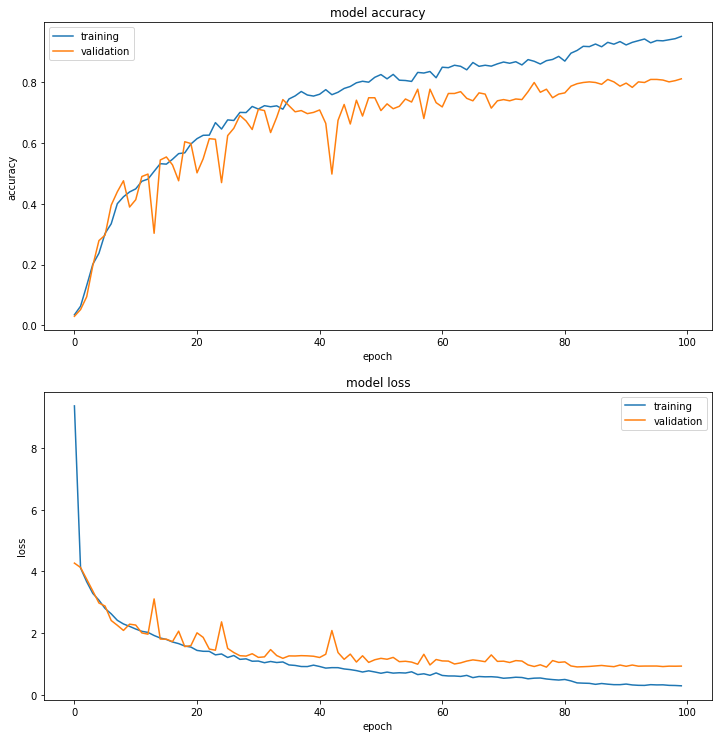

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

__Observations:__

- The result is quite stable as we can observe that the model is neither overfitting or underfitting.
- The difference between the train and validataion accuracy and loss is marginally off from each other, which is a good thing.
- We have achieved an val accuracy of __81.124%__ with ResNet 20 on 100 Epochs. 
- I even tried running it with deeper layer like ResNet32 and ResNet 110, but they were not producing a quite generalized model.
- This is quite okay given the size of our training dataset was quite less.

Our Model is very well trained !!!!

In [6]:
#load thmodel
model = load_model('/content/midas_resnet_v1.h5')

In [15]:
# lets also check the misclassificaion error
# We are  going to check out how our model has performed in identifying the right label for each of the images present in test dataset

def right_class(model):
  predicted_classes = model.predict(X_test)
  prediction = np.argmax(predicted_classes, axis=-1)
  class_idx = np.argmax(y_test, axis=-1)

  #compare them wether they are rightly classifid or not
  correct = np.nonzero(prediction==class_idx)[0]
  incorrect = np.nonzero(prediction!=class_idx)[0]
  return correct.shape[0], incorrect.shape[0]

model_preds = right_class(model)
print('Correct predictions: {} | Incorrect Predictions: {}'.format(model_preds[0], model_preds[1]))

Correct predictions: 404 | Incorrect Predictions: 94


__Observations:__

- Out of 498 images in our dataset our model was able to correctly classify 404 of them beonging to 62 classes which is quite good.
